In [35]:
import numpy as np
import pandas as pd
from keras.datasets import boston_housing
from keras import models, layers, optimizers

# Cargue de datos

Objetivo: predecir los precios de las viviendas.

In [11]:
(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

In [12]:
train_data.shape
#404 observaciones con 13 variables

(404, 13)

In [13]:
train_labels[0]
# Esta casa cuesta 15.2 mil dolares

15.2

# Preprocesamiento

## Normalización por medio de estandarización


In [14]:
mean = train_data.mean(axis = 0)
std = train_data.std(axis = 0)
train_data = (train_data - mean)/std
test_data = (test_data - mean)/std

# Estructuración del modelo

Vamos a crear una función que entregue modelos de datos. Para esto, se hara validación cruzada: rotar el set de validación en todo el set de entrenamiento.

In [30]:
def build_model_regression(lr_var, input_data):

    model = models.Sequential()

    model.add(layers.Dense(64, activation = 'relu', input_shape = (input_data,)))
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(1))
    # Dado que la predicción es el valor de la casa, esto es un numero continuo. En consecuencia, tiene una estructura lineal
    # y no es necesario agregarle una función de activación.


    model.compile(optimizer = optimizers.RMSprop(learning_rate = lr_var), # Se utiliza el mismo optimizador de siempre, solo que aquí se especifica el learning rate.
                  loss = 'mse',
                  metrics = ['mae'])
    return model

### Validación cruzada

Ahora, se hace la validación cruzada, donde se agrega las iteraciones que se haran con el set de validación sobre el set de entrenamiento.

Es decir, definimos en cuantas particiones K vamos a dividir el set de entrenamiento. Y a cada participación le probamos el set de validación. Esto se hace x cantidad de veces, que son las epocas.

In [38]:
k = 4  # numero de particiones de train_data en que se probara el set de validación, es decir, se haran 4 validaciones

num_val_samples = len(train_data)// k # numero de muestras que usaremos en el set de validación

num_epoch = 500 # numero de epocas

all_history = []

In [39]:
for i in range(k):
    print("Fold:", i)

    # datos de validacion, aquí solo usamos 1 partición.
    val_data = train_data[i*num_val_samples : (i+1)*num_val_samples] #datos de validación que vayan desde la obervacion a hasta la b.
    val_targets = train_labels[i*num_val_samples : (i+1)*num_val_samples]



    # datos de entrenamiento, aquí usamos las 3 particiones retsantes.

    # Aquí elimina del set de entrenamiento los datos usados en validacion
    partial_train_data = np.concatenate(
        [train_data[:i*num_val_samples],
         train_data[(i+1)*num_val_samples:]
         ],
        axis = 0)

    partial_train_targets = np.concatenate(
        [train_labels[:i*num_val_samples],
        train_labels[(i+1)*num_val_samples:]
        ],
        axis = 0)


    # Crear modelo, aquí usamos la función creada anteriormente.

    model = build_model_regression(0.001, 13) # recibe el learning rate y la cantidad de variables del df
    history = model.fit(partial_train_data, partial_train_targets,
                        epochs = num_epoch,
                        batch_size = 16, #tamaño de la muestra que se usa en cada epoca
                        validation_data = (val_data, val_targets),
                        verbose = 0
                        )

    all_history.append(history.history['val_mae'])

Fold: 0
Fold: 1
Fold: 2
Fold: 3


In [41]:
len(all_history[0])
# Hay 500 porque se fijaron 500 epocas, es decir, hay 500 resultados diferentes. Estos son los valores del mean absolute error (mae).
# Como hay 4 divisiones del set de entrenamiento, tenemos 500 resultados x 4 divisiones = 2000 resultados.
# El paso a seguir, es obtener la media de estos 2000 valores.

500

In [42]:
all_mae_avg = pd.DataFrame(all_history).mean(axis = 0)
all_mae_avg

0      19.310090
1      15.916263
2      11.809027
3       8.105880
4       5.955488
         ...    
495     2.508352
496     2.541903
497     2.561043
498     2.615602
499     2.597482
Length: 500, dtype: float64

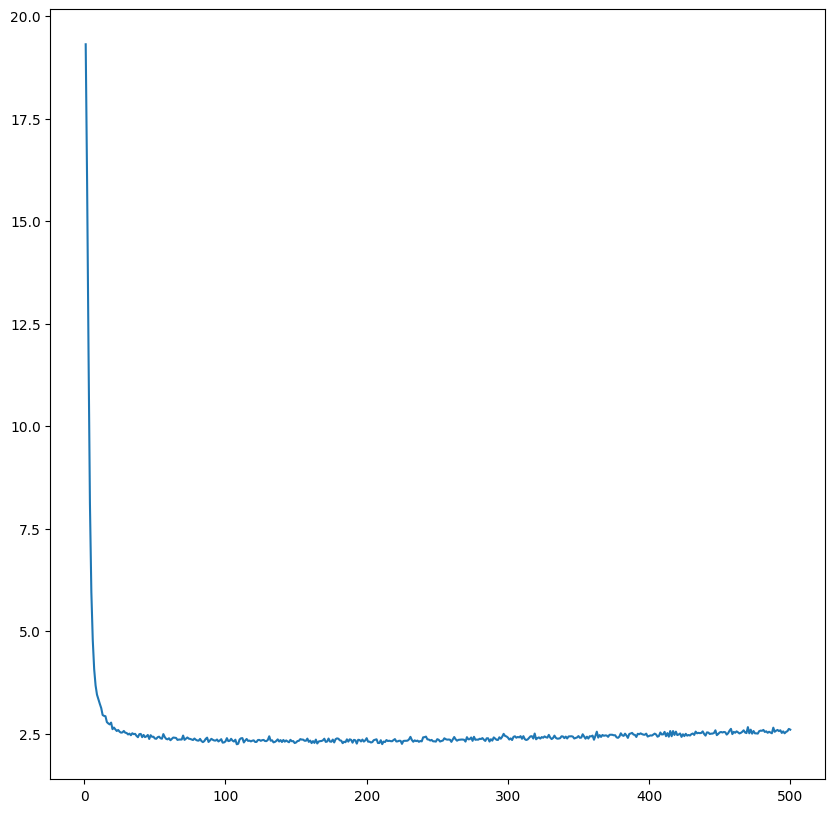

In [45]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
plt.plot(range(1, len(all_mae_avg)+1), all_mae_avg)
plt.show()

La grafica no muestra mucho, así que hacemos un zoom:

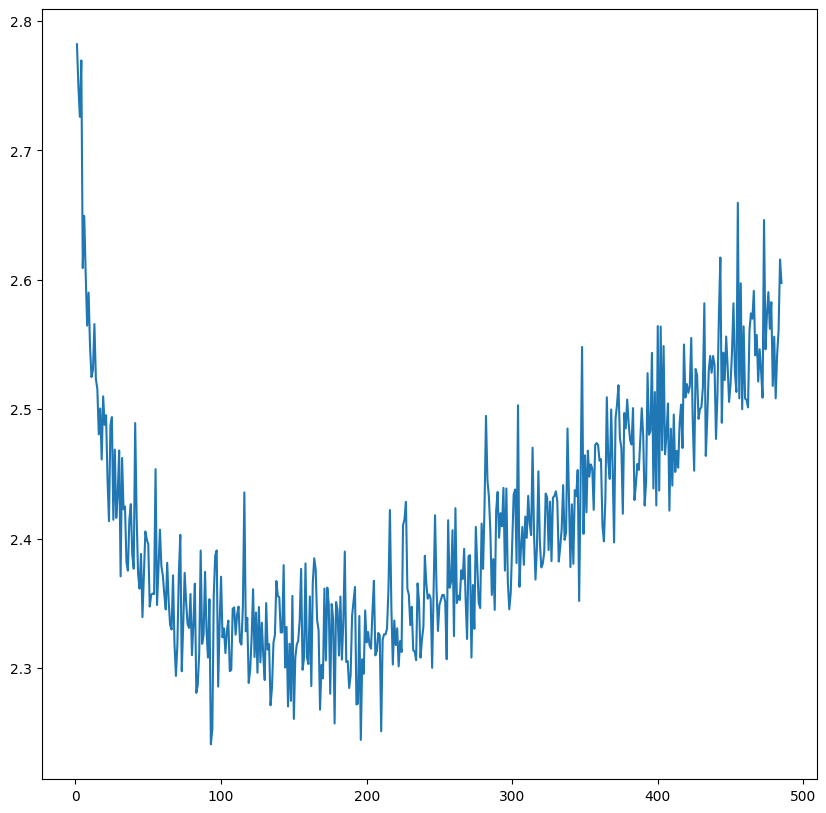

In [46]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
plt.plot(range(1, len(all_mae_avg[15:])+1), all_mae_avg[15:])
plt.show()

Esta grafica muestra el mae más bajo esta en la epoca cercana al 100

### Evaluación del modelo

In [47]:
model.evaluate(test_data, test_labels)

4/4 [==============================] - 0s 3ms/step - loss: 21.6262 - mae: 2.8913


[21.626192092895508, 2.891303062438965]

Se observa que el modelo tiene una desviación de 2.8 mil dolares

Dado que le mae esta cercano a la epoca 100, se recomienda reducir las epocas a un valor cercano a 100.